In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


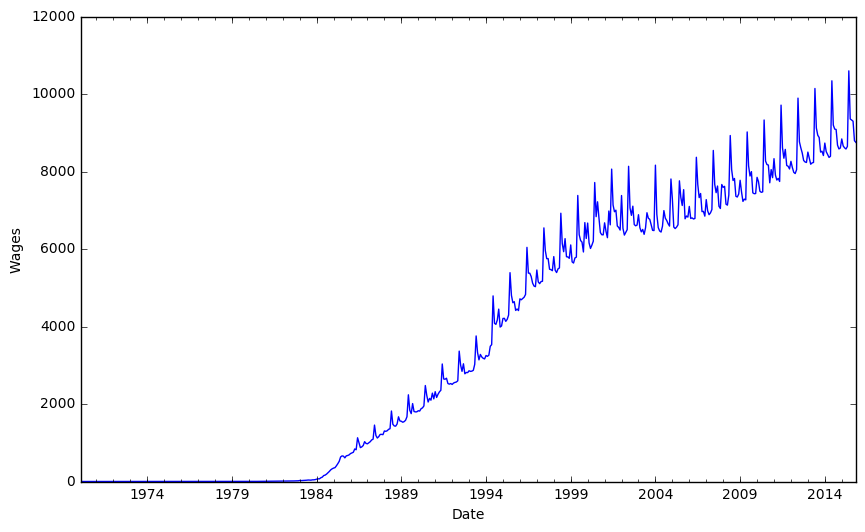

In [2]:
wages = pd.read_csv('BANKISRAEL-AW_8_M_CHAINED.csv', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
wages = wages.iloc[::-1] #потому что даты в csv идут в обратном порядке
figsize(10,6)
wages.Value.plot()
plt.ylabel('Wages')
pylab.show()

Критерий Дики-Фуллера: p =  0.977217977557


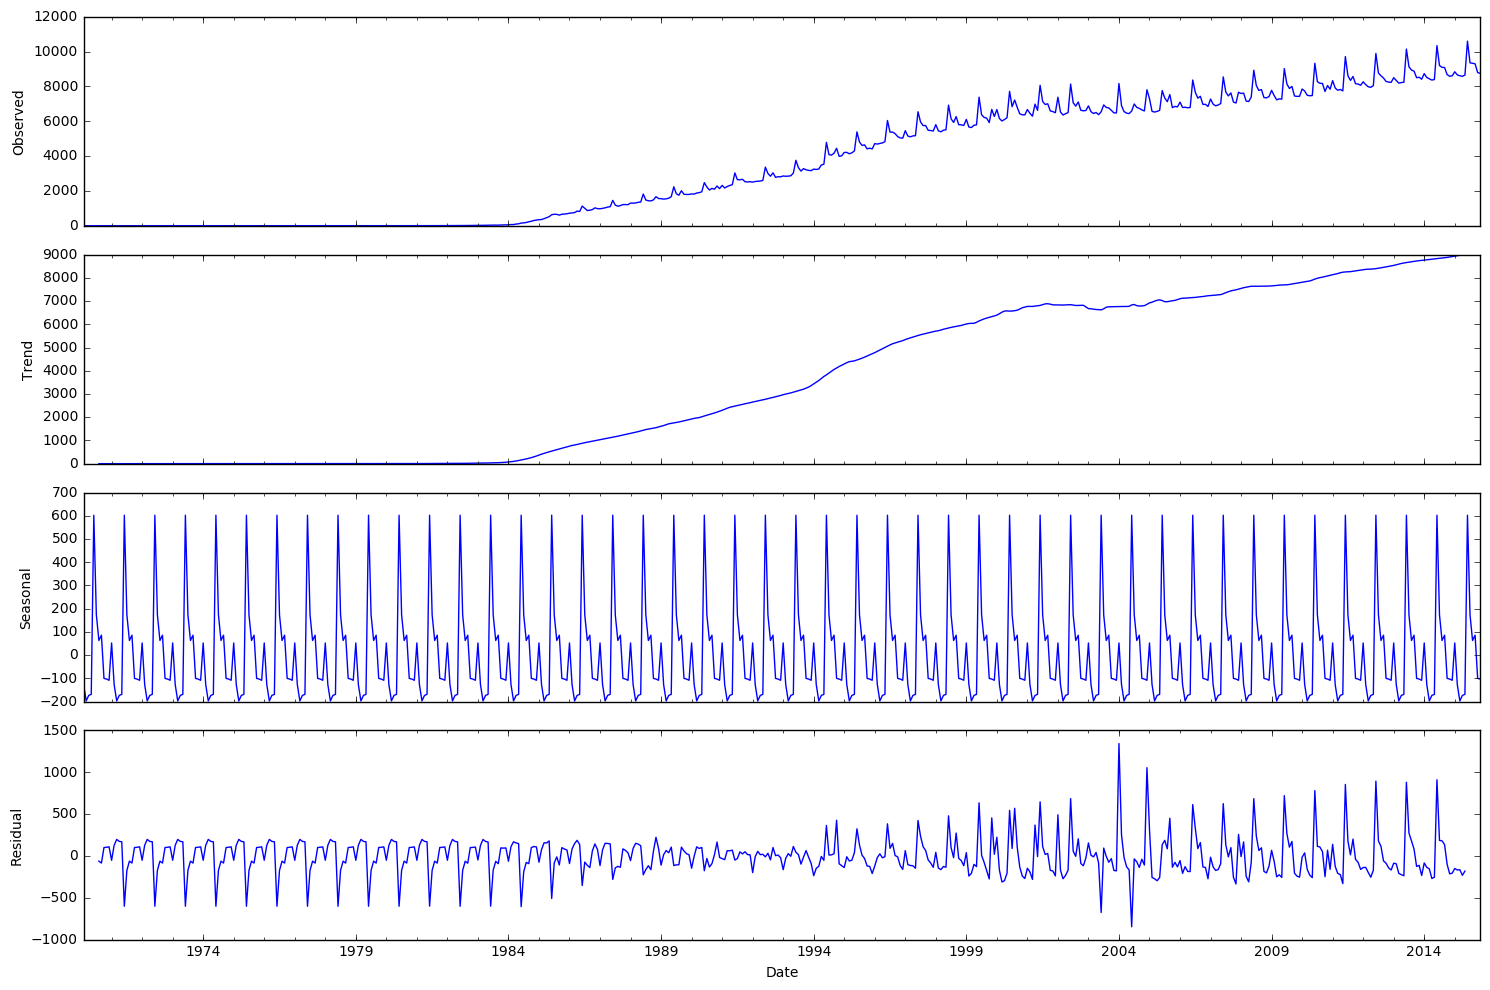

In [3]:
#сразу видно, что ряд стационарен, так как есть тренд и сезонность. Проверим с помощью критерия Дики-Фуллера

figsize(15,10)
sm.tsa.seasonal_decompose(wages.Value).plot()
print("Критерий Дики-Фуллера: p = ", sm.tsa.stattools.adfuller(wages.Value)[1])

Видим, что гипотезу о нестационарности ряда отвергнуть нельзя

Оптимальный параметр преобразования Бокса-Кокса:  0.216167280194
Критерий Дики-Фуллера: p = 0.498489172038


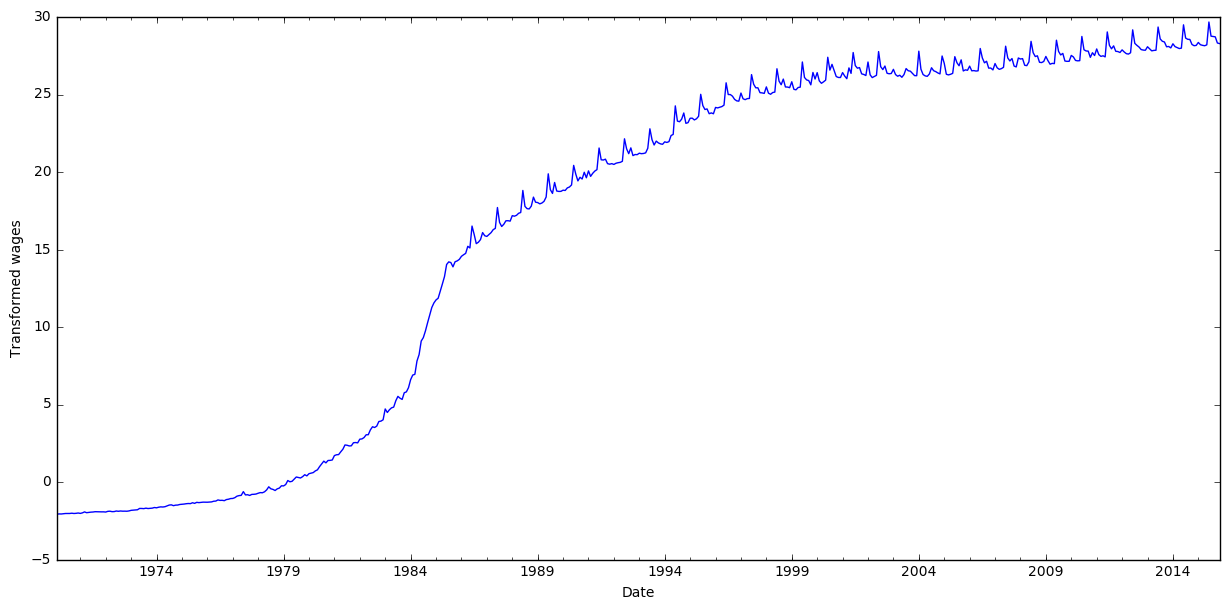

In [4]:
#делаем ряд стацонарным. Для этого применяем преобразования Бокса-Кокса

wages['box'], lmbda = stats.boxcox(wages.Value)
figsize(15,7)
wages.box.plot()
plt.ylabel('Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: ", lmbda)
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(wages.box)[1])

Критерий Дики-Фуллера все так же не отвергает гипотезу о нестационарности. Да и визуально виден тренд

Критерий Дики-Фуллера: p= 0.118191293676


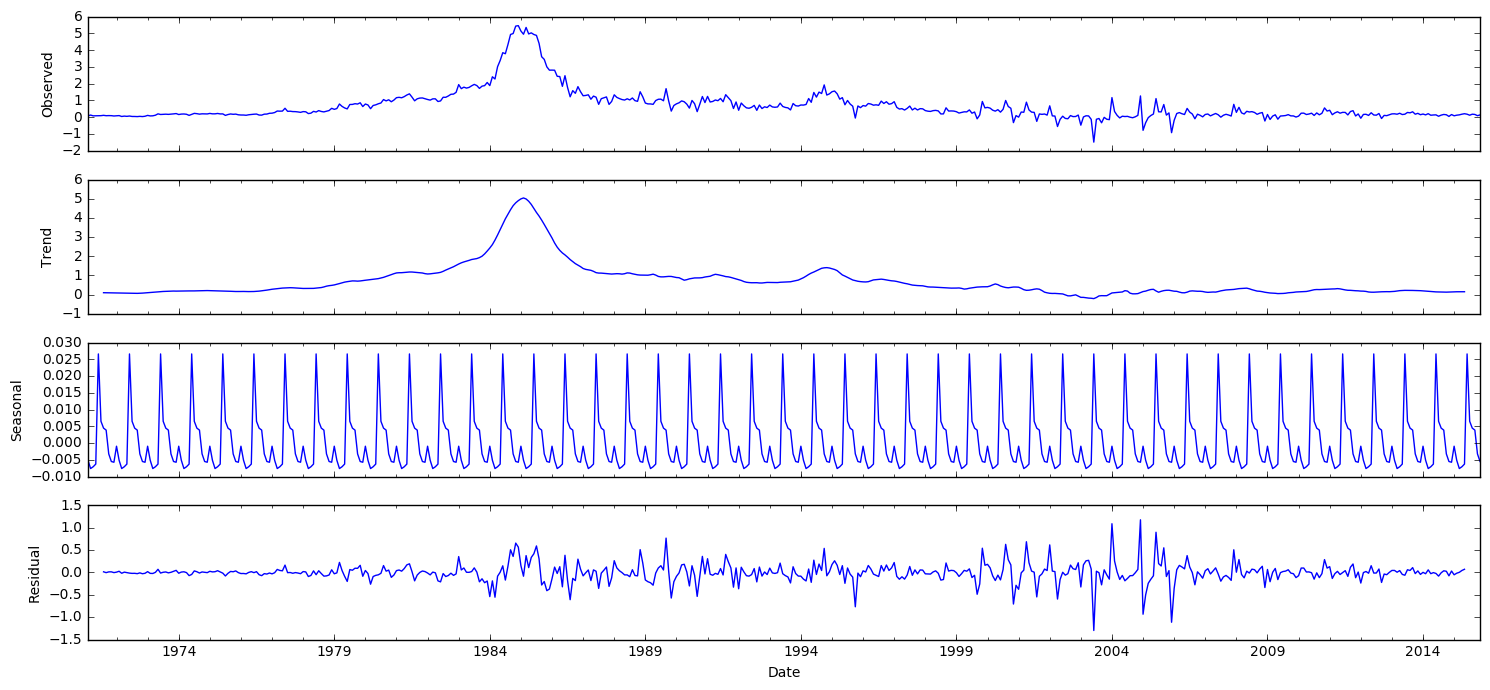

In [5]:
#Поэтому здесь делаем сезонное дифференцирование

wages['box_diff'] = wages.box - wages.box.shift(12)
sm.tsa.seasonal_decompose(wages.box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(wages.box_diff[12:])[1])

Гипотеза о нестационарности все еще не отвергнута

Критерий Дики-Фуллера: p = 8.03878750512e-10


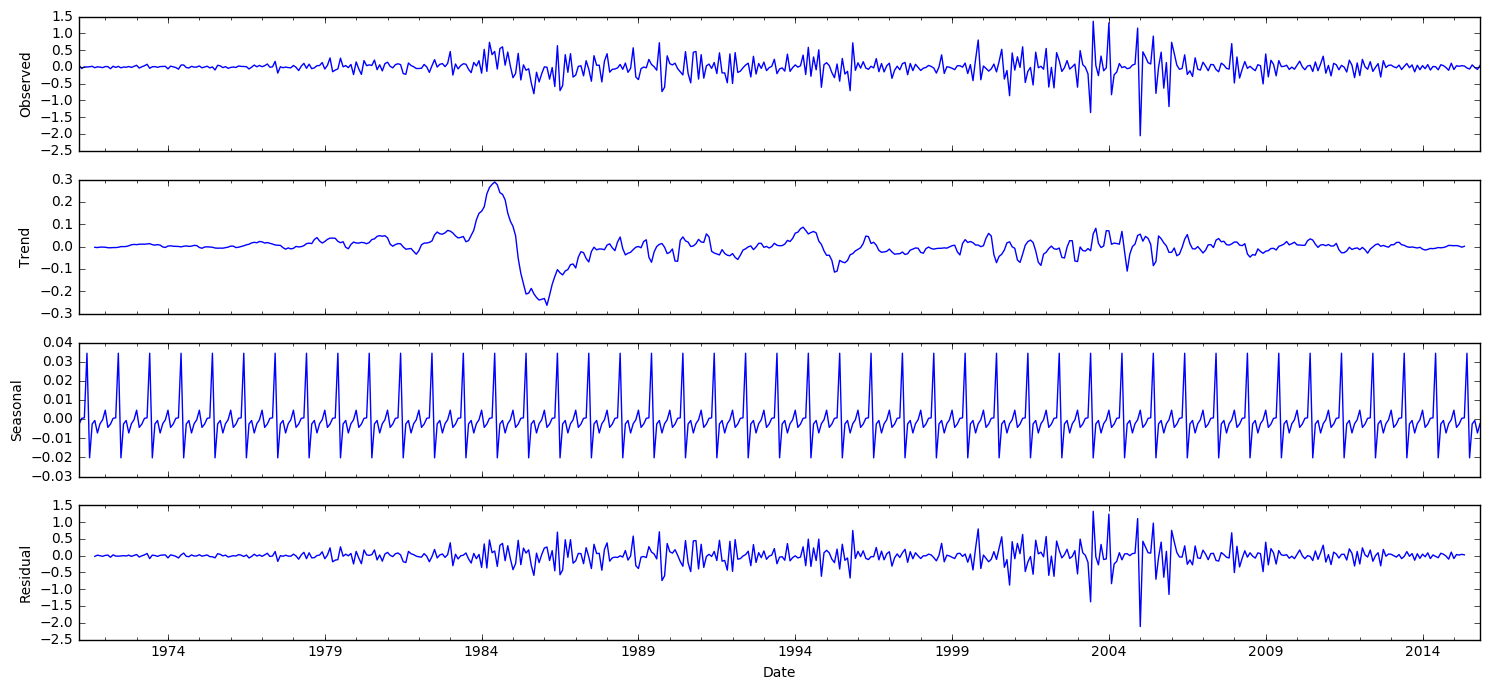

In [6]:
#Поэтому добавляем еще обычное дифференцирование

wages['box_diff2'] = wages.box_diff - wages.box_diff.shift(1)
sm.tsa.seasonal_decompose(wages.box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(wages.box_diff2[13:])[1])

И вот наконец-то гипотеза о нестационарности отвергается!

#### Подбор параметров модели

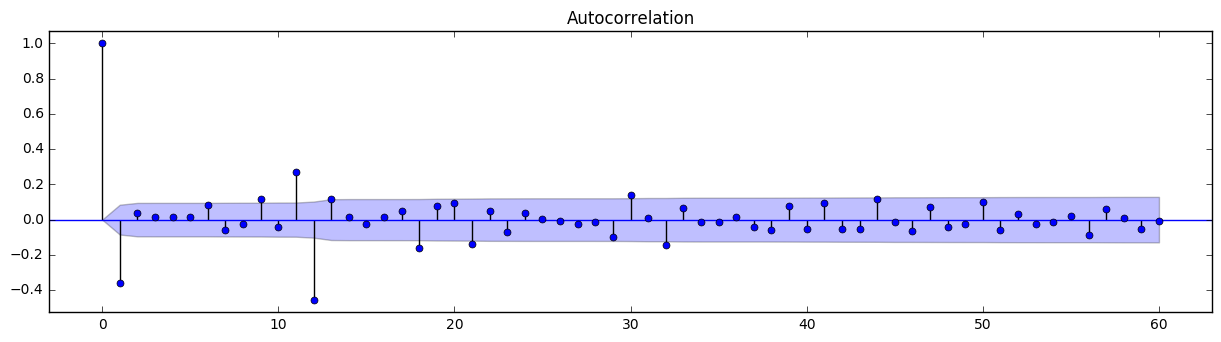

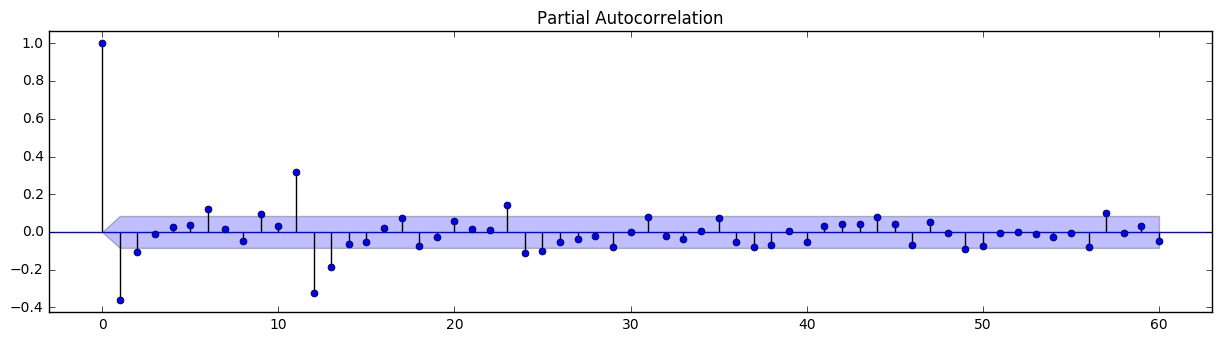

In [7]:
#смотрим на ACF и PACF

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.box_diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.box_diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()

* Q = 1, потому что на графике ACF наблюдается значимое значение на лаге 12 - это сезонность
* q = 11, потому что на графике ACF налюдается значимое значение на лагах 1, 9, 11 (12 - сезонный не подходит, значение q должно быть меньше сезонного, если сезонный больше 0)
* P = 2, потому что на графике PACF наблюдается значимое значение на лаге 24 - это сезонность
* p = 11, потому что на графике PACF налюдается значимое значение на лаге 1, 2, 3, 6, 11 (12 как и с q)
* возьму q=1 и p=6, потому что иначе придется перебирать слишком много вариантов

In [10]:
ps = range(0, 7)
d=1 #потому что сделали обычное дифференцирование
qs = range(0, 2)
Ps = range(0, 3)
D=1 #потому что сделали сезонное дифференцирование
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

84

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 13min 26s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
42  (3, 1, 0, 1) -74.972147
54  (4, 1, 0, 1) -74.570763
46  (3, 1, 2, 1) -73.523408
66  (5, 1, 0, 1) -73.284902
44  (3, 1, 1, 1) -73.108902


In [14]:
# Лучшая модель

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  550
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  43.486
Date:                            Wed, 21 Dec 2016   AIC                            -74.972
Time:                                    01:11:35   BIC                            -49.113
Sample:                                02-28-1970   HQIC                           -64.867
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4891      0.050      9.696      0.000       0.390       0.588
ar.L2          0.2511      0.026   

Критерий Стьюдента: p= 0.99438801396
Критерий Дики-Фуллера: p= 0.0


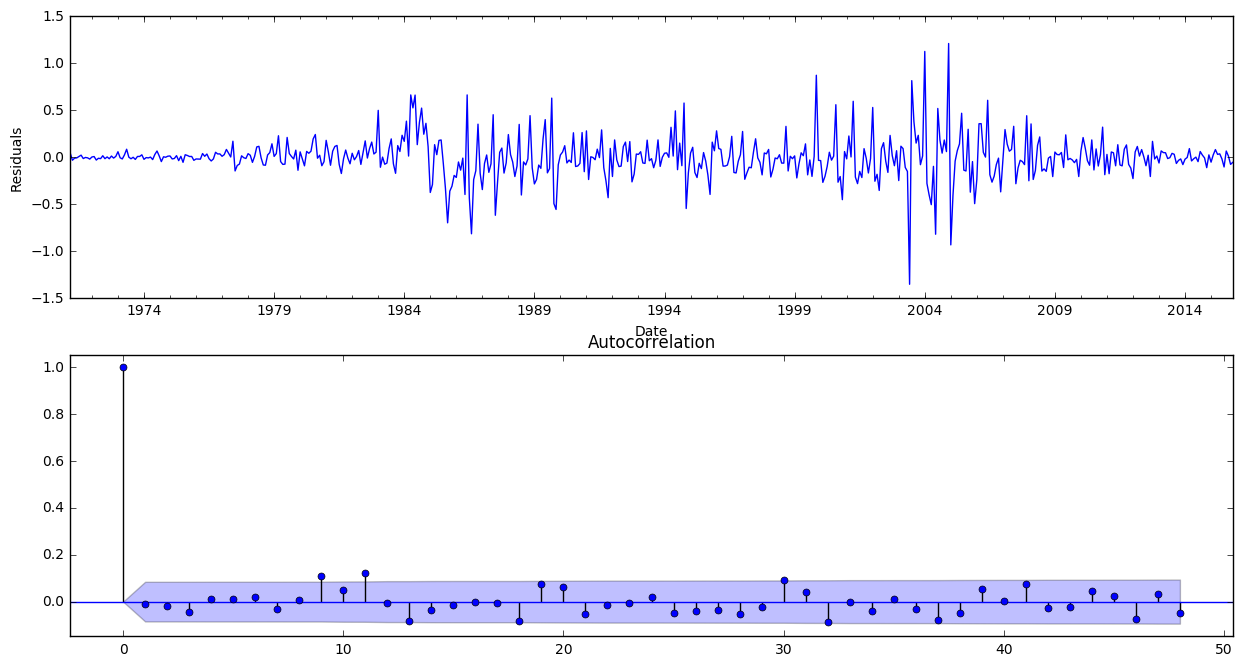

In [15]:
#Остатки модели

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=", stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

* Остатки должны быть несмещенными (среднее значение равно нулю). Чтобы проверить это можно применить критерий Стьюдента к гипотезе H0 (несмещенность). Получаем большое значение p-value, значит, H0 не отвергаем. 
* Также остатки должны быть стационарными (не зависить от времени). Это можно проверить с помощью критерия Дики-Фуллера. p_value маленький, значит, отвергаем нулевую гипотезу о нестационарности. 
* И остатки должны быть неавтокоррелированными (не зависить от предыдущих наблюдений). На автокоррелограмме видно, что таких точек нет.

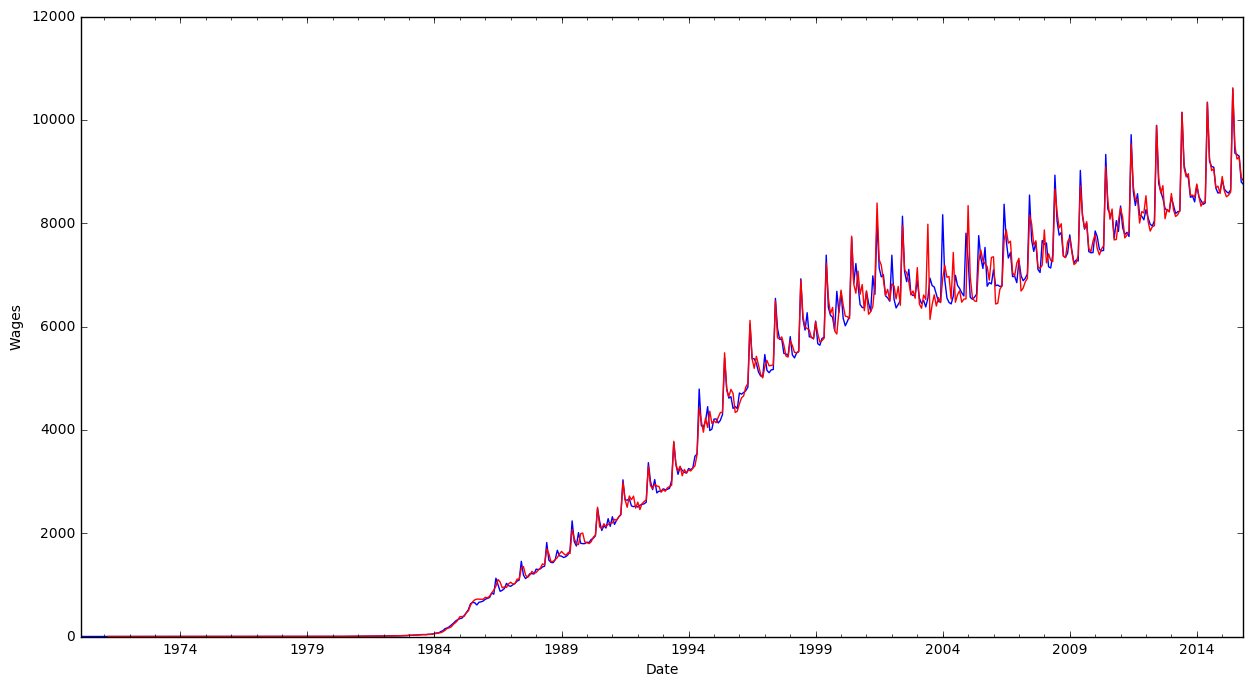

In [16]:
# Смотрим, насколько хорошо модель описывает данные

wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
wages.Value.plot()
wages.model[13:].plot(color='r')
plt.ylabel('Wages')

#### Прогноз

C:\Users\Katya\Anaconda3\lib\site-packages\statsmodels\base\data.py:551: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(squeezed, index=self.predict_dates)


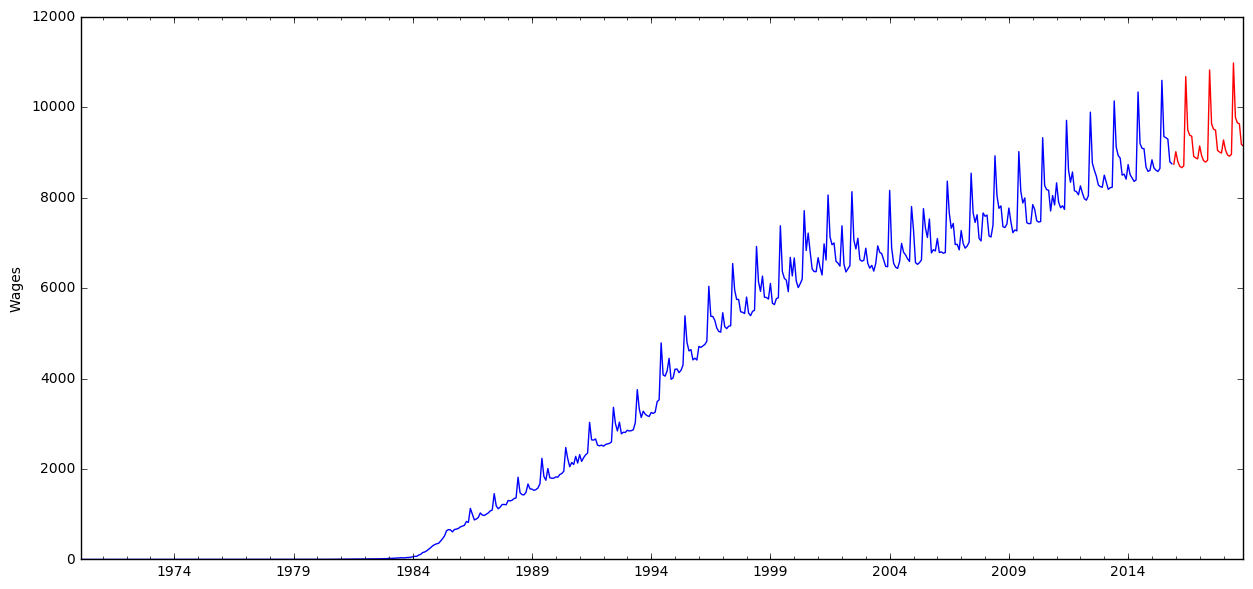

In [17]:
from pandas.tseries.offsets import MonthBegin

wages2 = wages[['Value']]
date_list = [datetime.datetime.strptime("31/12/2015", "%d/%m/%Y") + relativedelta(months=x) for x in range(0,36)]
#date_list = pd.date_range("1/10/2015", periods=36, freq='m') + MonthBegin(n=0)
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=550, end=600), lmbda)

plt.figure(figsize(15,7))
wages2.Value.plot()
wages2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()